<h1 style="color:orange">QDA Exam - Feb 2024</h1> 
Francesco Marco Riboli - 10502512 - 8CFU

# Exercise 1

The measured diameters of the shafts produced over two shifts are reported in `diameter_phase1.csv`. The 
columns of the table report a sequential index (‘idx’ column), the measurements in mm (‘diam’ column) and 
the shift (‘shift’ column) at which the data were collected.

In [164]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
from statsmodels.tsa.arima.model import ARIMA

# Import the dataset
data = pd.read_csv('diameter_phase1.csv')

# Inspect the dataset
data.head()

,idx,diam,shift
0,1,19.9775,1
1,2,20.0573,1
2,3,20.0216,1
3,4,19.9500,1
4,5,19.8468,1


In [165]:
data.describe()

,idx,diam,shift
count,80.0000,80.0000,80.0000
mean,40.5000,20.1060,1.2500
std,23.2379,0.1397,0.4357
min,1.0000,19.7917,1.0000
25%,20.7500,19.9958,1.0000
50%,40.5000,20.1110,1.0000
75%,60.2500,20.2046,1.2500
max,80.0000,20.4468,2.0000


In [166]:
# Define the measure on which we will be running the analysis
measure='diam'

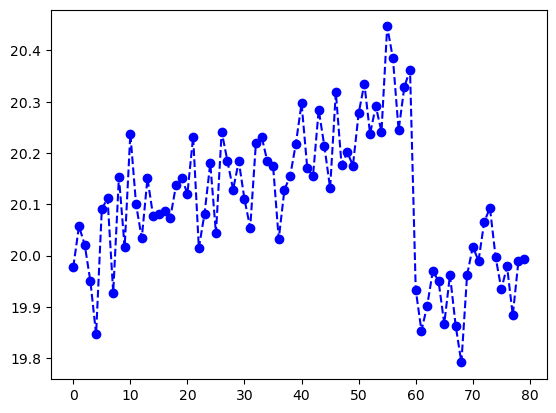

In [167]:
# Plot the data first
plt.plot(data[measure], color='b', linestyle='--', marker='o')

We can see that the Diameter is trending, with a clear shift when changing from Shift1 to Shift2

## a) Fitting of the appropriate model to the dataset

In [168]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data[measure], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.000


> The runs test gives a null p-value, this means that the data are <span style="color:red"> not random </span>. 
>
> Plot also the autocorrelation and partial autocorrelation functions of the data. Use the `plot_acf` and `plot_pacf` functions from the `statsmodels` package.

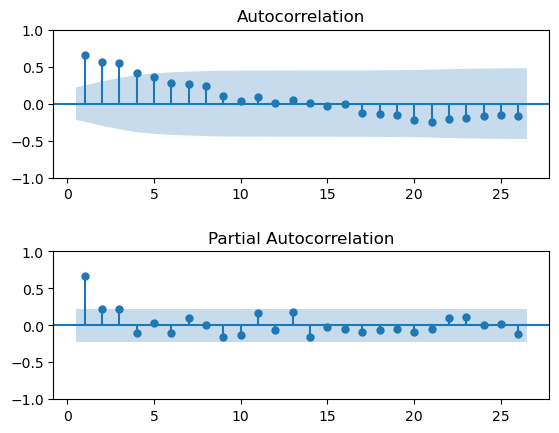

In [169]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data[measure], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data[measure], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> ACF is linearly decading, while PACF shows two spikes for lags 1 and a minor one for lag 2
>
> The process is NON-STATIONARY.

At this point the exercise solutions check for normality...

Shapiro-Wilk test p-value = 0.953


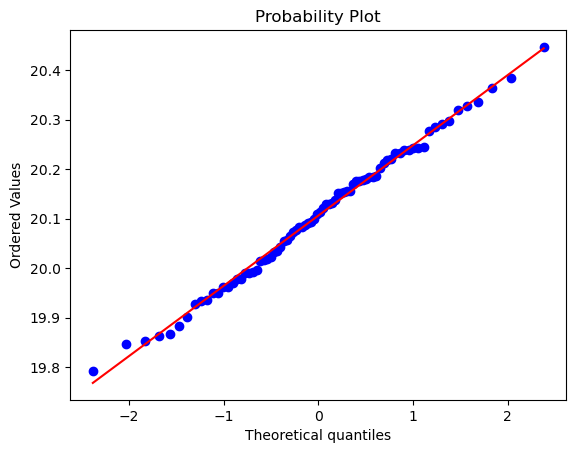

In [170]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(data[measure])
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(data[measure], dist="norm", plot=plt)
plt.show()

The data is normal, as shown by a SW p-value of 0.953

Let's now fit a linear model using the time index and the shift as regressors

In [171]:
#calculate a regression model with constant, shift and time index
import statsmodels.api as sm

x = data[["idx","shift"]]

# Add a constant to the model.
x = sm.add_constant(x) 

y = data['diam']
model = sm.OLS(y, x).fit()

# Print out the statistics
import qda
qda.summary(model)


REGRESSION EQUATION
-------------------
diam =  + 20.415 const + 0.005 idx -0.412 shift

COEFFICIENTS
------------
 Term    Coef  SE Coef  T-Value     P-Value
const 20.4146   0.0253 806.7788 5.8228e-153
  idx  0.0051   0.0005   9.6031  8.3001e-15
shift -0.4122   0.0283 -14.5441  8.6130e-24

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0726 0.7367     0.7298

ANALYSIS OF VARIANCE
---------------------
    Source   DF    Adj SS    Adj MS     F-Value     P-Value
Regression  2.0    1.1352    0.5676    107.7150  4.8759e-23
     const  1.0 3429.9929 3429.9929 650891.9804 5.8228e-153
       idx  1.0    0.4860    0.4860     92.2204  8.3001e-15
     shift  1.0    1.1147    1.1147    211.5317  8.6130e-24
     Error 77.0    0.4058    0.0053         NaN         NaN
     Total 79.0    1.5410       NaN         NaN         NaN


> Check on residuals
>
>$ \varepsilon \sim NID  (\mathbf{0}, \sigma^2 \mathbf{I}) $
> 
>Normal and independently distributed

> Let's check residuals. To accept the model, we also need to verify the assumption that residuals are normal and independently distributed.

> First, we check normality of residuals. 

Shapiro-Wilk test p-value on the residuals = 0.994


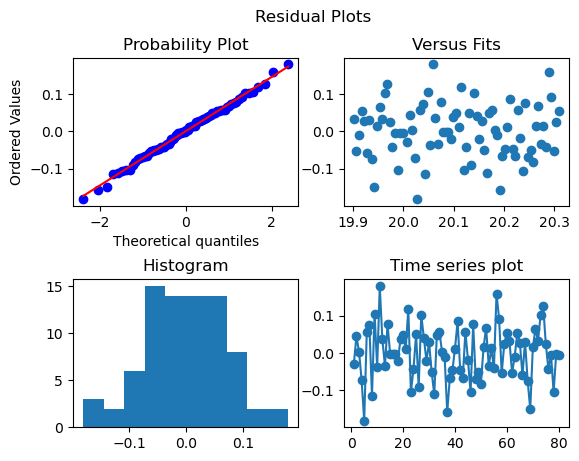

In [172]:
#NORMALITY OF RESIDUALS

fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(model.fittedvalues, model.resid)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(model.resid)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')

_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

> - The normal probability plot (top left) shows a normal distribution of the residuals. 
> - The histogram (bottom left) confirms normality. 
> - On top right, residuals versus fits are shown. 
> - The bottom right panel shows the time series plot of the residuals. 
>
> Based on the Shapiro-Wilk test, the assumption on normality of residuals is accepted.

Runs test p-value on the residuals = 1.000


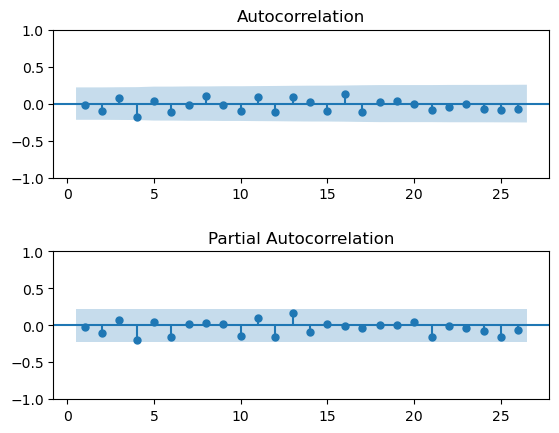

In [173]:
#RANDOMNESS OF RESIDUALS
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> Residuals do not show autocorrelation. Assumption on randomness of residuals is accepted.

> Use the `conf_int()` method to compute the confidence interval on the coefficients of the model for any specified value of alpha.

In [174]:
# Calculate the confidence interval
CI_beta1 = model.conf_int(alpha=0.05).loc['idx']
print('The confidence interval for beta1 is [%.3f, %.3f]' % (CI_beta1[0], CI_beta1[1]))

CI_beta2 = model.conf_int(alpha=0.05).loc['shift']
print('The confidence interval for beta2 is [%.3f, %.3f]' % (CI_beta2[0], CI_beta2[1]))

The confidence interval for beta1 is [0.004, 0.006]
The confidence interval for beta2 is [-0.469, -0.356]


Let's now plot the model versus the actual data, for demonstrative purposes

In [175]:
# Predict the diameter using the fitted linear model
data['predicted_diam'] = model.predict(x)

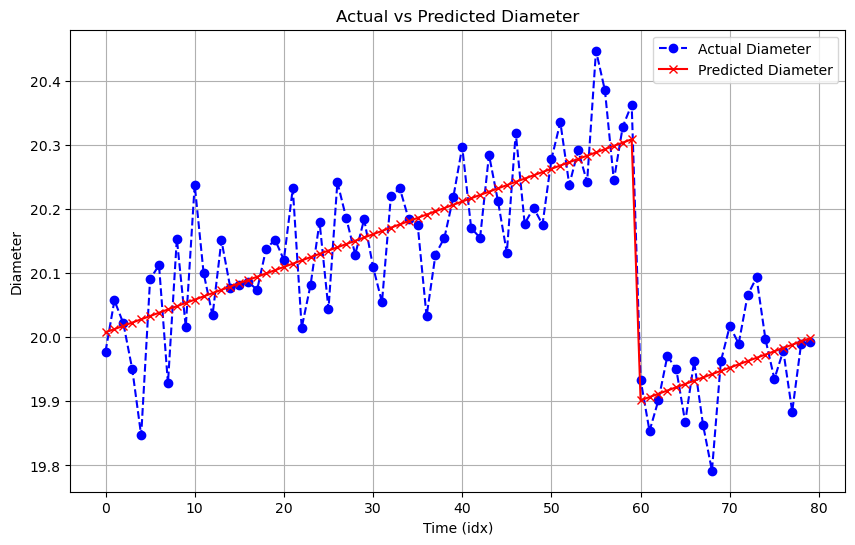

In [176]:
# Plot the actual and predicted diameter values on the same plot
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['diam'], marker='o', linestyle='--', color='b', label='Actual Diameter')
plt.plot(data.index, data['predicted_diam'], marker='x', linestyle='-', color='r', label='Predicted Diameter')
plt.title('Actual vs Predicted Diameter')
plt.xlabel('Time (idx)')
plt.ylabel('Diameter')
plt.legend()
plt.grid(True)
plt.show()

Let's predict some additional values, just for fun

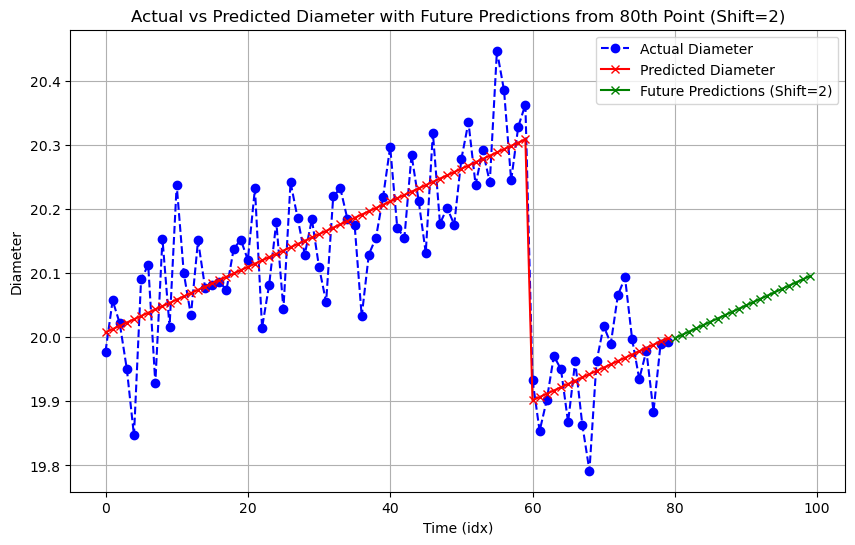

In [177]:
# Prepare future index starting from the last point of the original dataset with shift = 2
future_index_from_80_shift_2 = np.arange(len(data), len(data) + 20)
future_X_from_80_shift_2 = pd.DataFrame({
    'constant': [1] * 20,
    'idx': future_index_from_80_shift_2,
    'shift': [2] * 20,
})

# Predict future diameter values starting from the 80th point with shift = 2
future_predictions_from_80_shift_2 = model.predict(future_X_from_80_shift_2)

# Plot the actual and predicted diameter values along with the future predictions
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['diam'], marker='o', linestyle='--', color='b', label='Actual Diameter')
plt.plot(data.index, data['predicted_diam'], marker='x', linestyle='-', color='r', label='Predicted Diameter')
plt.plot(future_index_from_80_shift_2, future_predictions_from_80_shift_2, marker='x', linestyle='-', color='g', label='Future Predictions (Shift=2)')
plt.title('Actual vs Predicted Diameter with Future Predictions from 80th Point (Shift=2)')
plt.xlabel('Time (idx)')
plt.ylabel('Diameter')
plt.legend()
plt.grid(True)
plt.show()

## b) Design the appropriate control charts to monitor the diameter of the shafts (use K = 3)

We will use a Special‐Cause Chart: I‐MR control chart on model residuals: it is used to monitor the random component of the process

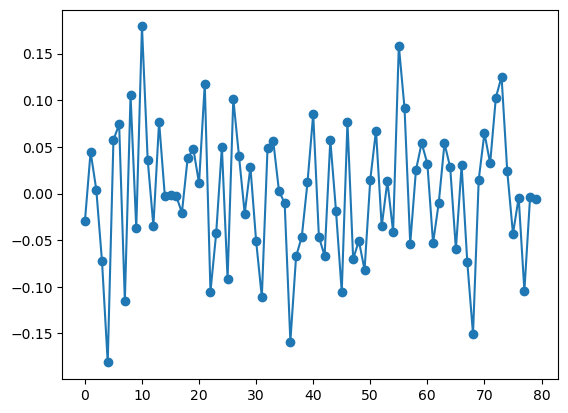

In [178]:
# Convert residuals to DataFrame
residuals_df = pd.DataFrame(model.resid, columns=['Residuals'])
# Plot the data
plt.plot(residuals_df['Residuals'], 'o-')
plt.show()

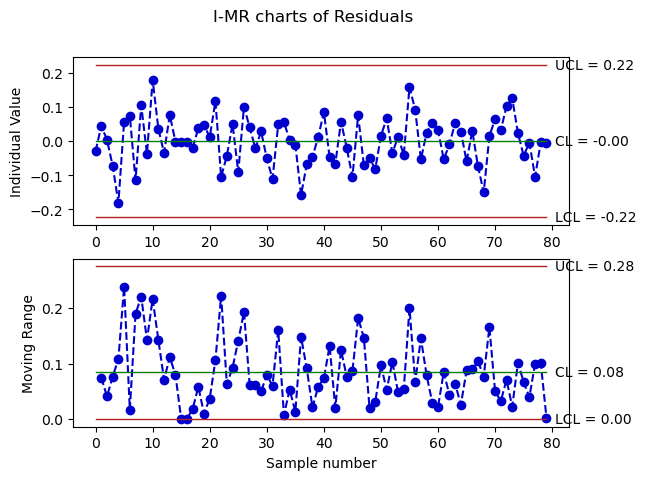

,Residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,-0.0300,NaN,0.224,-2.5313e-15,-0.224,NaN,0.2752,0.0843,0,NaN
1,0.0447,0.0747,0.224,-2.5313e-15,-0.224,NaN,0.2752,0.0843,0,NaN
2,0.0038,0.0409,0.224,-2.5313e-15,-0.224,NaN,0.2752,0.0843,0,NaN
3,-0.0728,0.0767,0.224,-2.5313e-15,-0.224,NaN,0.2752,0.0843,0,NaN
4,-0.1811,0.1083,0.224,-2.5313e-15,-0.224,NaN,0.2752,0.0843,0,NaN


In [179]:
import qda
k=3 # given in the exercise
data_IMR = qda.ControlCharts.IMR(residuals_df,'Residuals',k)
data_IMR.head()

Let's find the OOC point in the MR chart

In [180]:
# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['MR_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: []


No OCC points are found

## c) Using the control chart(s) designed in point 1 (phase 1), check if the data collected for the following 20 shafts produced during shift 2 (stored in `diameter_phase2.csv`) are in control. Report the index of the  OOC points, if any. 

In [181]:
# We append the 20 points to the initial dataset
data_phase2 = pd.read_csv('diameter_phase2.csv')

# Append the new dataset to the original dataset
data_combined = pd.concat([data, data_phase2])

# Ensure the combined data index is continuous
data_combined.reset_index(drop=True, inplace=True)

# Add a constant term for the linear regression
data_combined['constant'] = 1

# Define the independent variables (shift, index, constant)
X_combined = data_combined[['constant','idx','shift']]

# Define the dependent variable (diam)
y_combined = data_combined['diam']

# Predict the diameter using the previously fitted linear model
data_combined['predicted_diam'] = model.predict(X_combined)

# Calculate the residuals
data_combined['residuals'] = data_combined['diam'] - data_combined['predicted_diam']

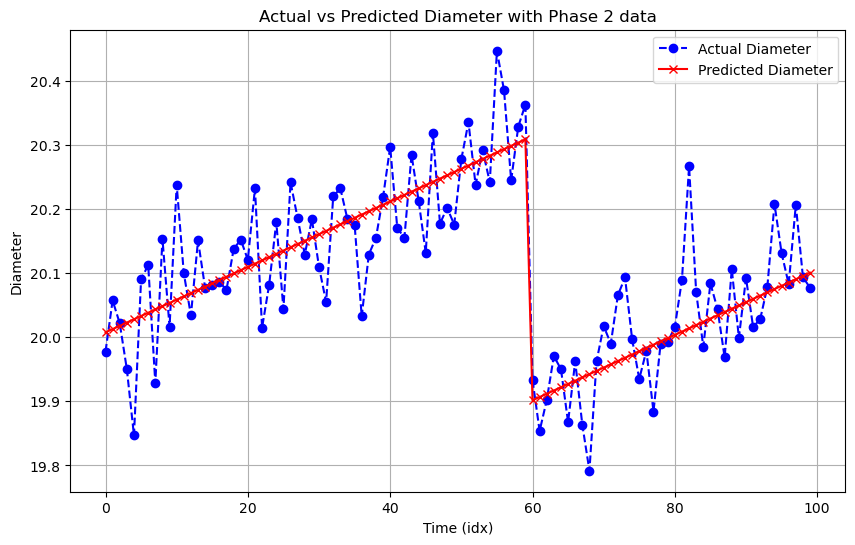

In [182]:
# Plot the actual and predicted diameter values along with the future predictions
plt.figure(figsize=(10, 6))
plt.plot(data_combined.index, data_combined['diam'], marker='o', linestyle='--', color='b', label='Actual Diameter')
plt.plot(data_combined.index, data_combined['predicted_diam'], marker='x', linestyle='-', color='r', label='Predicted Diameter')
plt.title('Actual vs Predicted Diameter with Phase 2 data')
plt.xlabel('Time (idx)')
plt.ylabel('Diameter')
plt.legend()
plt.grid(True)
plt.show()

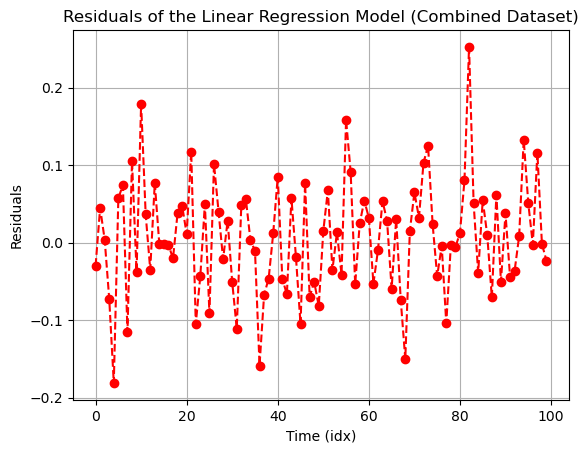

In [183]:
# Plot the residuals for the combined dataset
plt.plot(data_combined.index, data_combined['residuals'], marker='o', linestyle='--', color='r')
plt.title('Residuals of the Linear Regression Model (Combined Dataset)')
plt.xlabel('Time (idx)')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

We still need to check for normality and non-randomness in the residuals of the model on the whole dataset

Shapiro-Wilk test p-value on the residuals = 0.688


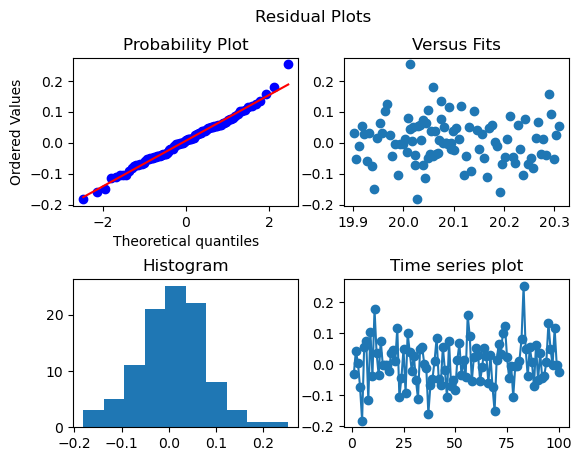

In [184]:
#NORMALITY OF RESIDUALS (PHASE 2)
residuals_phase2=data_combined['residuals']
fitted_phase2=data_combined['predicted_diam']

fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals_phase2, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(fitted_phase2, residuals_phase2)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals_phase2)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals_phase2)+1), residuals_phase2, 'o-')

_, pval_SW_res = stats.shapiro(residuals_phase2)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.688


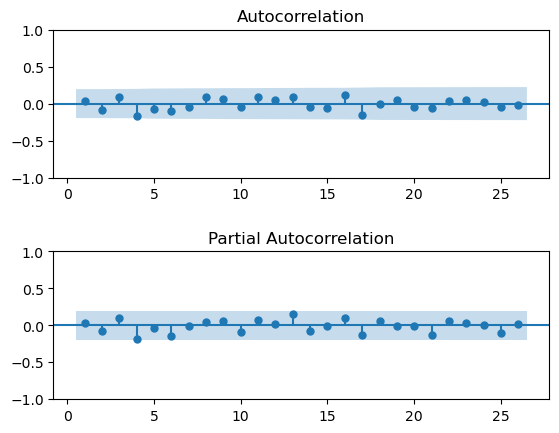

In [185]:
#RANDOMNESS OF RESIDUALS
_, pval_runs_res = runstest_1samp(residuals_phase2, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals_phase2, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals_phase2, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> Residuals do not show autocorrelation. Assumption on randomness of residuals is accepted.

We can move on by deifining the I-MR control chart of the new dataset

In [186]:
print(type(residuals_phase2))

<class 'pandas.core.series.Series'>


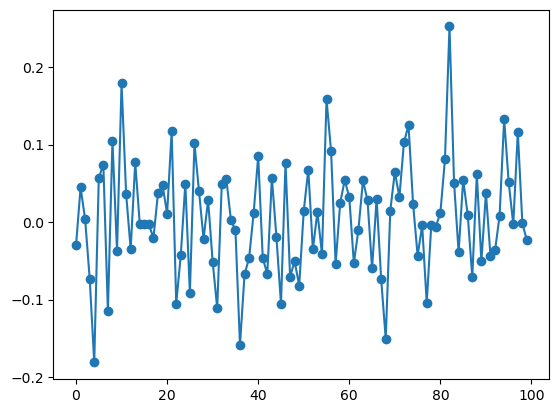

<class 'pandas.core.frame.DataFrame'>


In [187]:
# Convert residuals to DataFrame
residuals_df = residuals_phase2.to_frame()
# Plot the data
plt.plot(residuals_df['residuals'], 'o-')
plt.show()
print(type(residuals_df))

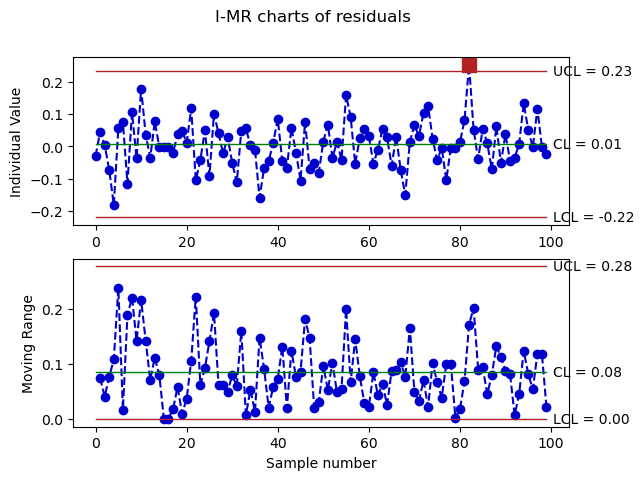

,residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,-0.0300,NaN,0.2319,0.006,-0.2199,NaN,0.2775,0.085,0,NaN
1,0.0447,0.0747,0.2319,0.006,-0.2199,NaN,0.2775,0.085,0,NaN
2,0.0038,0.0409,0.2319,0.006,-0.2199,NaN,0.2775,0.085,0,NaN
3,-0.0728,0.0767,0.2319,0.006,-0.2199,NaN,0.2775,0.085,0,NaN
4,-0.1811,0.1083,0.2319,0.006,-0.2199,NaN,0.2775,0.085,0,NaN


In [188]:
import qda
k=3 # given in the exercise
data_IMR = qda.ControlCharts.IMR(residuals_df,'residuals',k)
data_IMR.head()

In [189]:
# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [82]


Point 83 (index 82) is OOC